In [ ]:
os.chdir('/home/oban/Desktop/Volga/stellar-classification')
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, 
                              WeightedRandomSampler, random_split)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
hdul = fits.open('data/dataset3_subset2.fits')
hdul1 = fits.open('data/dataset_subset4.fits')
dataset = hdul[1].data
dataset_old = hdul1[1].data
hdul.close()
hdul1.close()

problem = np.where((dataset_old.TYPED_ID == "HD134439") | 
                   (dataset_old.TYPED_ID == "Ross  889"))
dataset_old = np.delete(dataset_old, problem)

In [ ]:
# trsvchn's answer on stackoverflow at: https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

class GaussianNoise(torch.nn.Module):
    def __init__(self, mean: float, sigma_r: tuple):
        super().__init__()
        self.mean = mean
        self.sigma_r = sigma_r

    def forward(self, spectra):
        sigma = torch.Tensor((1)).uniform_(*self.sigma_r).cuda()
        noise = self.mean + torch.randn_like(spectra).cuda() * sigma
        out = spectra + noise
        return out

def split_dataset(data, label, dataset, split, **kwargs):
    x = data[split]
    y = label[split]
    return dataset((x,y),**kwargs)

In [ ]:
flux_numpy = dataset.FLUX.newbyteorder().byteswap()

from eval_utils import label_field, stellar_metrics

label_f = label_field(dataset, regr=False, new=True)
# label_f_old = label_field(dataset_old, regr=False, new=False)

classes = label_f.classes
indices = label_f.ord_to_idx(classes)

splits = list(range(0,len(dataset)))

train, test_val = train_test_split(splits, test_size=0.3, 
                                   random_state=1337, stratify=indices)

ones = np.where(np.unique(classes[test_val],return_counts=True)[1] == 1)

if len(ones) != 0: 
    for i in ones[0]:
        label = label_f.idx_to_ord(i)
        idx = np.where(classes[train] == label)[0][-1]
        real_idx = train.pop(idx)
        test_val.append(real_idx)

val, test = train_test_split(test_val, test_size=0.5, 
                             random_state=1337, stratify=indices[test_val])

assert sum([len(set(classes[i])) for i in [train, val, test]]) % 3 == 0

In [ ]:
flux = torch.tensor(flux_numpy).cuda().float()
labels = torch.tensor(indices).cuda().int() #indices

gaussian_noise = GaussianNoise(mean=0,sigma_r=(0.01,0.05))

train_iter = split_dataset(flux, labels, CustomTensorDataset, 
                           train, transform=gaussian_noise)

val_iter = split_dataset(flux, labels, CustomTensorDataset, val)

test_iter = split_dataset(flux, labels, CustomTensorDataset, test)

weights = pd.Series(indices[train]).value_counts()

random_sample = WeightedRandomSampler(weights=max(weights)/weights[indices[train]].values,
                                      num_samples=len(indices[train]))

train_loader = DataLoader(train_iter, 128, sampler=random_sample)
val_loader = DataLoader(val_iter, 16)
test_loader = DataLoader(test_iter, 16)

In [ ]:
def trainer(dataloader, model, loss, optimizer):
    losses = []
    preds = []
    actuals = []
    model.train()
    for fluxes, labels in dataloader:

        labels = labels.type(torch.LongTensor).cuda()
        fluxes = fluxes.cuda()

        optimizer.zero_grad()
        class_scores = model(fluxes)
        train_loss = loss(class_scores, labels)
        train_loss.backward()
        optimizer.step()
    
        losses.append(train_loss.item())
        preds.extend(class_scores.argmax(dim=1).tolist())
        actuals.extend(labels.tolist())

    inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
    f1 = inter_sm.f1_macro()
    qwk = inter_sm.two_stage_qwk('q')

    return losses, f1, qwk

def validator(dataloader, model, loss, test=False):
    losses = []
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        if not test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                val_loss = loss(class_scores, labels)
                losses.append(val_loss.item())
                preds.extend(class_scores.argmax(dim=1).tolist())
                actuals.extend(labels.tolist())

            inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
            f1 = inter_sm.f1_macro()
            qwk = inter_sm.two_stage_qwk('q')

            return losses, f1, qwk

        if test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                class_preds = class_scores.argmax(dim=1)
                preds.extend(class_preds.tolist())
                actuals.extend(labels.tolist())

            return preds, actuals

class2coords = torch.tensor(
    label_f.to_regr(np.unique(classes),idx=False),
    dtype=torch.float32)

class OrdinalLoss(nn.Module):
    def __init__(self, class2coords, alpha, betas=[1,1]):
        super().__init__()
        # register as a buffer so it moves with .to(device), but is not trained
        self.register_buffer('coords', class2coords)  
        self.alpha = torch.tensor(alpha).cuda()
        self.betas = torch.tensor(betas).cuda()

    def forward(self, logits, target):
        probs = logits.softmax(dim=1)
        pred_xy = probs @ self.coords
        true_xy = self.coords[target]

        loss_xent = F.cross_entropy(logits, target)
        loss_ord = F.mse_loss(self.betas*pred_xy, self.betas*true_xy)
        return (1-self.alpha)*loss_xent + self.alpha*loss_ord

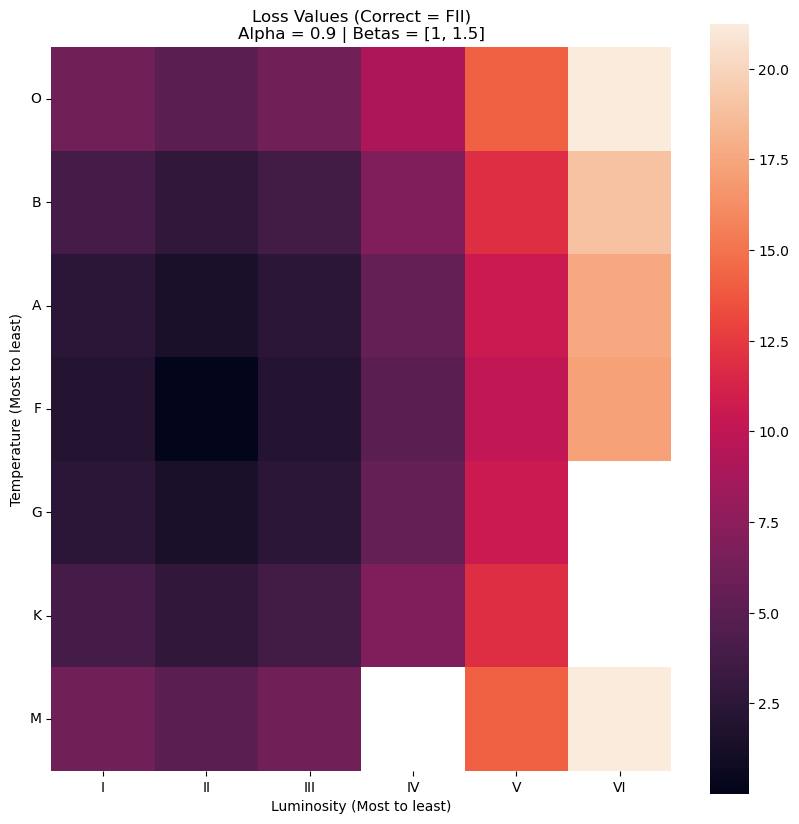

In [ ]:
alpha = 0.9
betas = [1,1.5]
correct = 19

loss = OrdinalLoss(class2coords, alpha, betas).cuda()

x = torch.zeros([12,39]).cuda()
x[:,correct] = 10

los_l = lambda y: loss(x, torch.Tensor([y]*12).type(torch.LongTensor).cuda()).item()

losses = [los_l(y) for y in range(39)]

losses.insert(37,np.nan)
losses.insert(34,np.nan)
losses.insert(29,np.nan)

plt.figure(figsize=(10,10))
sns.heatmap(np.array(losses).reshape(-1,6),
            square=True,xticklabels=label_f.strs[1],
            yticklabels=label_f.strs[0])
plt.yticks(rotation=0)
plt.ylabel('Temperature (Most to least)')
plt.xlabel('Luminosity (Most to least)')
plt.title(f'''Loss Values (Correct = {label_f.to_str(correct, True)})
Alpha = {alpha} | Betas = {betas}''');

In [ ]:
# from torchmetrics.regression import MeanAbsoluteError
from models.conv1d import StarClassifier4

filters = [1,32,128,512,2048,512,128,32]
strides = [1, 2, 2, 2, 2, 2, 2, 2]

model_config = {'filter_sizes':filters,
                'kernels':[3,5,7],
                'strides':strides,
                'output_dim':len(label_f.idx_dict),
                'hidden_dim':2048,
                'dropout':0,
                'input_shape':flux_numpy.shape[-1]}

torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

classifier = StarClassifier4(**model_config).to('cuda')

custom_loss = OrdinalLoss(class2coords, 0.75, betas=[1,1.5]).cuda()

adamw = torch.optim.AdamW(classifier.parameters(), lr=0.00005, betas=(0.9,0.95))

In [ ]:
folder_name = 'final7_starclassifier4_test'
path = f'models/weights/conv1d/cls/{folder_name}'
if not os.path.exists(path):
    os.mkdir(path)

epochs = 200

losses = []
metrics = []

best_f1 = 0

for i in range(epochs):
    tr_l, tr_f1, tr_qwk = trainer(train_loader, classifier, custom_loss, adamw)
    vl_l, vl_f1, vl_qwk = validator(val_loader, classifier, custom_loss)

    losses.extend([tr_l, vl_l])
    metrics.append((
        np.mean(tr_l), tr_f1, tr_qwk,
        np.mean(vl_l), vl_f1, vl_qwk
    ))

    if vl_f1 > best_f1 * 1.01:
        early_stop_counter = 0
        best_f1 = vl_f1
        print(f"New best model found at epoch {i}")
        torch.save(classifier.state_dict(), f'{path}/best_conv1d_cls_{i}.pth.tar')
    else:
        early_stop_counter += 1

    # if early_stop_counter >= 10:
        # print(f'Early stopping at epoch {i}')
        # break
    if i%5 == 0:
        printout = '\t|\t'.join([str(np.round(x,2)) for x in metrics[-1]])
        print(f'''{i+1}/{epochs} \t|\t: {printout}''')

New best model found at epoch 0
1/200 	|	: 4.6	|	0.01	|	[0.58 0.11]	|	3.34	|	0.0	|	[0.75 0.14]
New best model found at epoch 1
New best model found at epoch 2
New best model found at epoch 3
New best model found at epoch 4
New best model found at epoch 5
6/200 	|	: 0.96	|	0.5	|	[0.98 0.74]	|	0.85	|	0.36	|	[0.96 0.45]
New best model found at epoch 6
New best model found at epoch 7
New best model found at epoch 10
11/200 	|	: 0.75	|	0.6	|	[0.99 0.81]	|	0.8	|	0.43	|	[0.96 0.38]
New best model found at epoch 11
New best model found at epoch 13
16/200 	|	: 0.58	|	0.66	|	[0.99 0.83]	|	0.72	|	0.47	|	[0.98 0.56]
New best model found at epoch 16
New best model found at epoch 19
21/200 	|	: 0.53	|	0.72	|	[0.99 0.88]	|	0.68	|	0.49	|	[0.97 0.6 ]
New best model found at epoch 21
New best model found at epoch 23
26/200 	|	: 0.47	|	0.73	|	[0.99 0.88]	|	0.68	|	0.49	|	[0.98 0.51]
New best model found at epoch 27
New best model found at epoch 30
31/200 	|	: 0.44	|	0.75	|	[0.99 0.9 ]	|	0.69	|	0.54	|	[0.9

In [ ]:
metrics

[(4.597285489241282,
  0.012794751302050128,
  (0.5779657987849173, 0.1122289946775632),
  3.3401815037668485,
  0.0005101193442000617,
  (0.7456754389839004, 0.13820934769431403)),
 (2.621026888489723,
  0.03388816438244476,
  (0.7193648280957896, 0.14712555569313068),
  1.5476771401770322,
  0.01743076110030449,
  (0.6551147411625544, 0.09483534591162579)),
 (1.5311985487739246,
  0.15659922365034434,
  (0.8386657451588204, 0.4184110984411088),
  1.1016505117769595,
  0.16074425513076543,
  (0.9108593845934309, 0.4815480698124013)),
 (1.2365704538921516,
  0.3597564201146964,
  (0.9460093676405599, 0.6014043338603243),
  0.8708195495016781,
  0.30660278238311617,
  (0.9488451345193056, 0.3591763249893063)),
 (1.0333881253997486,
  0.45219982214876214,
  (0.9759473224235407, 0.705618625603113),
  1.0400521773615001,
  0.32573810268935116,
  (0.9368280380081601, 0.4104808784308186)),
 (0.9554643606146177,
  0.5034334996261395,
  (0.9768716452734065, 0.7379300950166133),
  0.84548896955

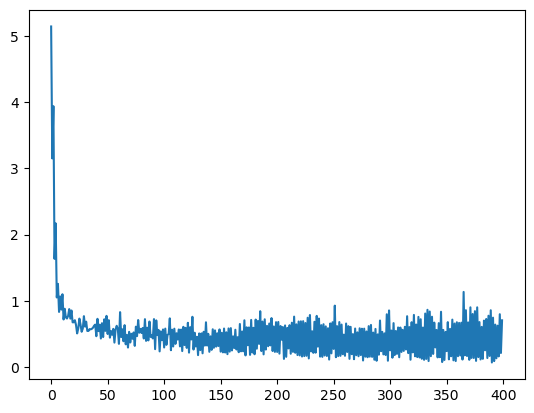

In [ ]:
plt.plot([x[0] for x in losses])

In [ ]:
len([x[0] for x in losses])

400

In [ ]:
[x[0] for x in losses]

[5.145236968994141,
 3.151832342147827,
 3.941290855407715,
 1.6338303089141846,
 2.1705334186553955,
 1.0509796142578125,
 1.25662362575531,
 0.8322731852531433,
 1.0657199621200562,
 0.8673832416534424,
 1.0991671085357666,
 0.71825110912323,
 0.879679262638092,
 0.7501415014266968,
 0.7328706979751587,
 0.7705656290054321,
 0.8746285438537598,
 0.7311191558837891,
 0.8537092208862305,
 0.6750924587249756,
 0.6760897636413574,
 0.706941545009613,
 0.635683536529541,
 0.5070055723190308,
 0.581368088722229,
 0.7311959862709045,
 0.6419458389282227,
 0.5323688387870789,
 0.5805144309997559,
 0.7679295539855957,
 0.610397458076477,
 0.6855036020278931,
 0.5448711514472961,
 0.5447499752044678,
 0.5725167989730835,
 0.5689026713371277,
 0.5769292712211609,
 0.5928515791893005,
 0.622992217540741,
 0.6403322219848633,
 0.46524226665496826,
 0.7278666496276855,
 0.541793704032898,
 0.6396061182022095,
 0.43053731322288513,
 0.6618325114250183,
 0.4522016644477844,
 0.7205345630645752,
 0.5

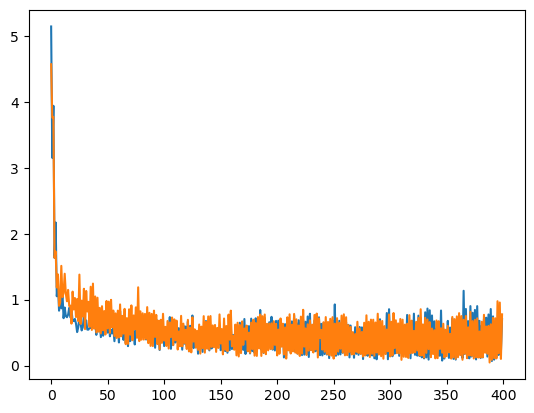

In [ ]:
plt.plot([x[0] for x in losses])
plt.plot([x[1] for x in losses])

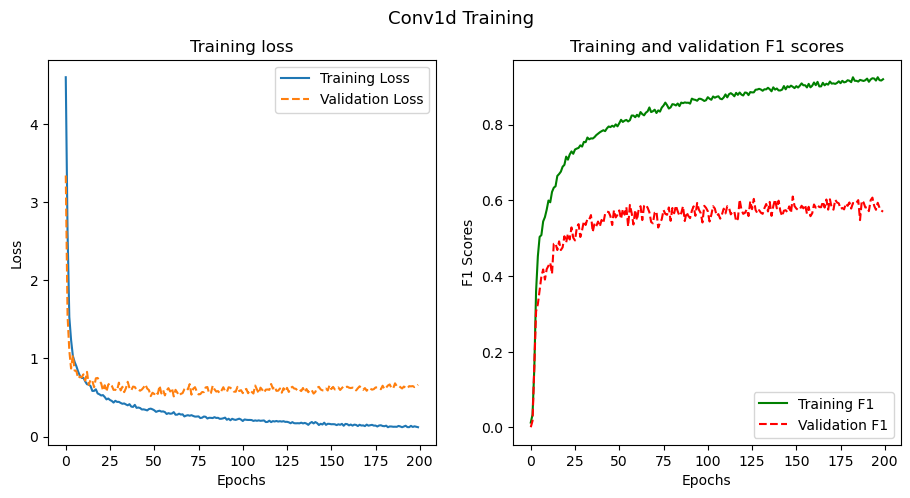

In [ ]:
fig, (l_ax, f_ax) = plt.subplots(1,2, figsize=(11,5))
fig.suptitle('Conv1d Training',fontsize=13)

l_ax.plot([x[0] for x in metrics])
l_ax.plot([x[3] for x in metrics], linestyle='--')
l_ax.legend(['Training Loss','Validation Loss'])
l_ax.set_xlabel('Epochs')
l_ax.set_ylabel('Loss')
l_ax.set_title('Training loss');

f_ax.plot([x[1] for x in metrics], c='green')
f_ax.plot([x[4] for x in metrics],c='red',linestyle='--')
f_ax.legend(['Training F1','Validation F1'])
f_ax.set_xlabel('Epochs')
f_ax.set_ylabel('F1 Scores')
f_ax.set_title('Training and validation F1 scores');

Text(0.5, 1.0, 'Quadratic Weighted Kappa Scores')

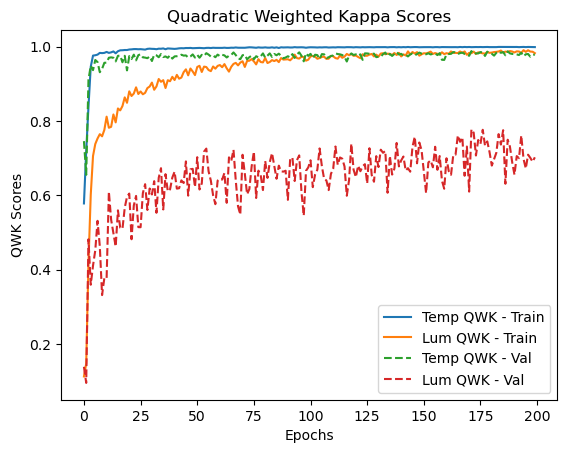

In [ ]:
plt.plot([x[2] for x in metrics])
plt.plot([x[5] for x in metrics], linestyle='--')
plt.legend([
    'Temp QWK - Train',
    'Lum QWK - Train',
    'Temp QWK - Val',
    'Lum QWK - Val'])
plt.xlabel('Epochs')
plt.ylabel('QWK Scores')
plt.title('Quadratic Weighted Kappa Scores')

In [ ]:
folder_name = 'final7_starclassifier4_test'
path = f'models/weights/conv1d/cls/{folder_name}'
best_i = 148

classifier3 = StarClassifier4(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

F1 Macro: 62.80%
Mean Absolute Error: 0.19
Q-Weighted Kappa: 97.30%, 60.28%


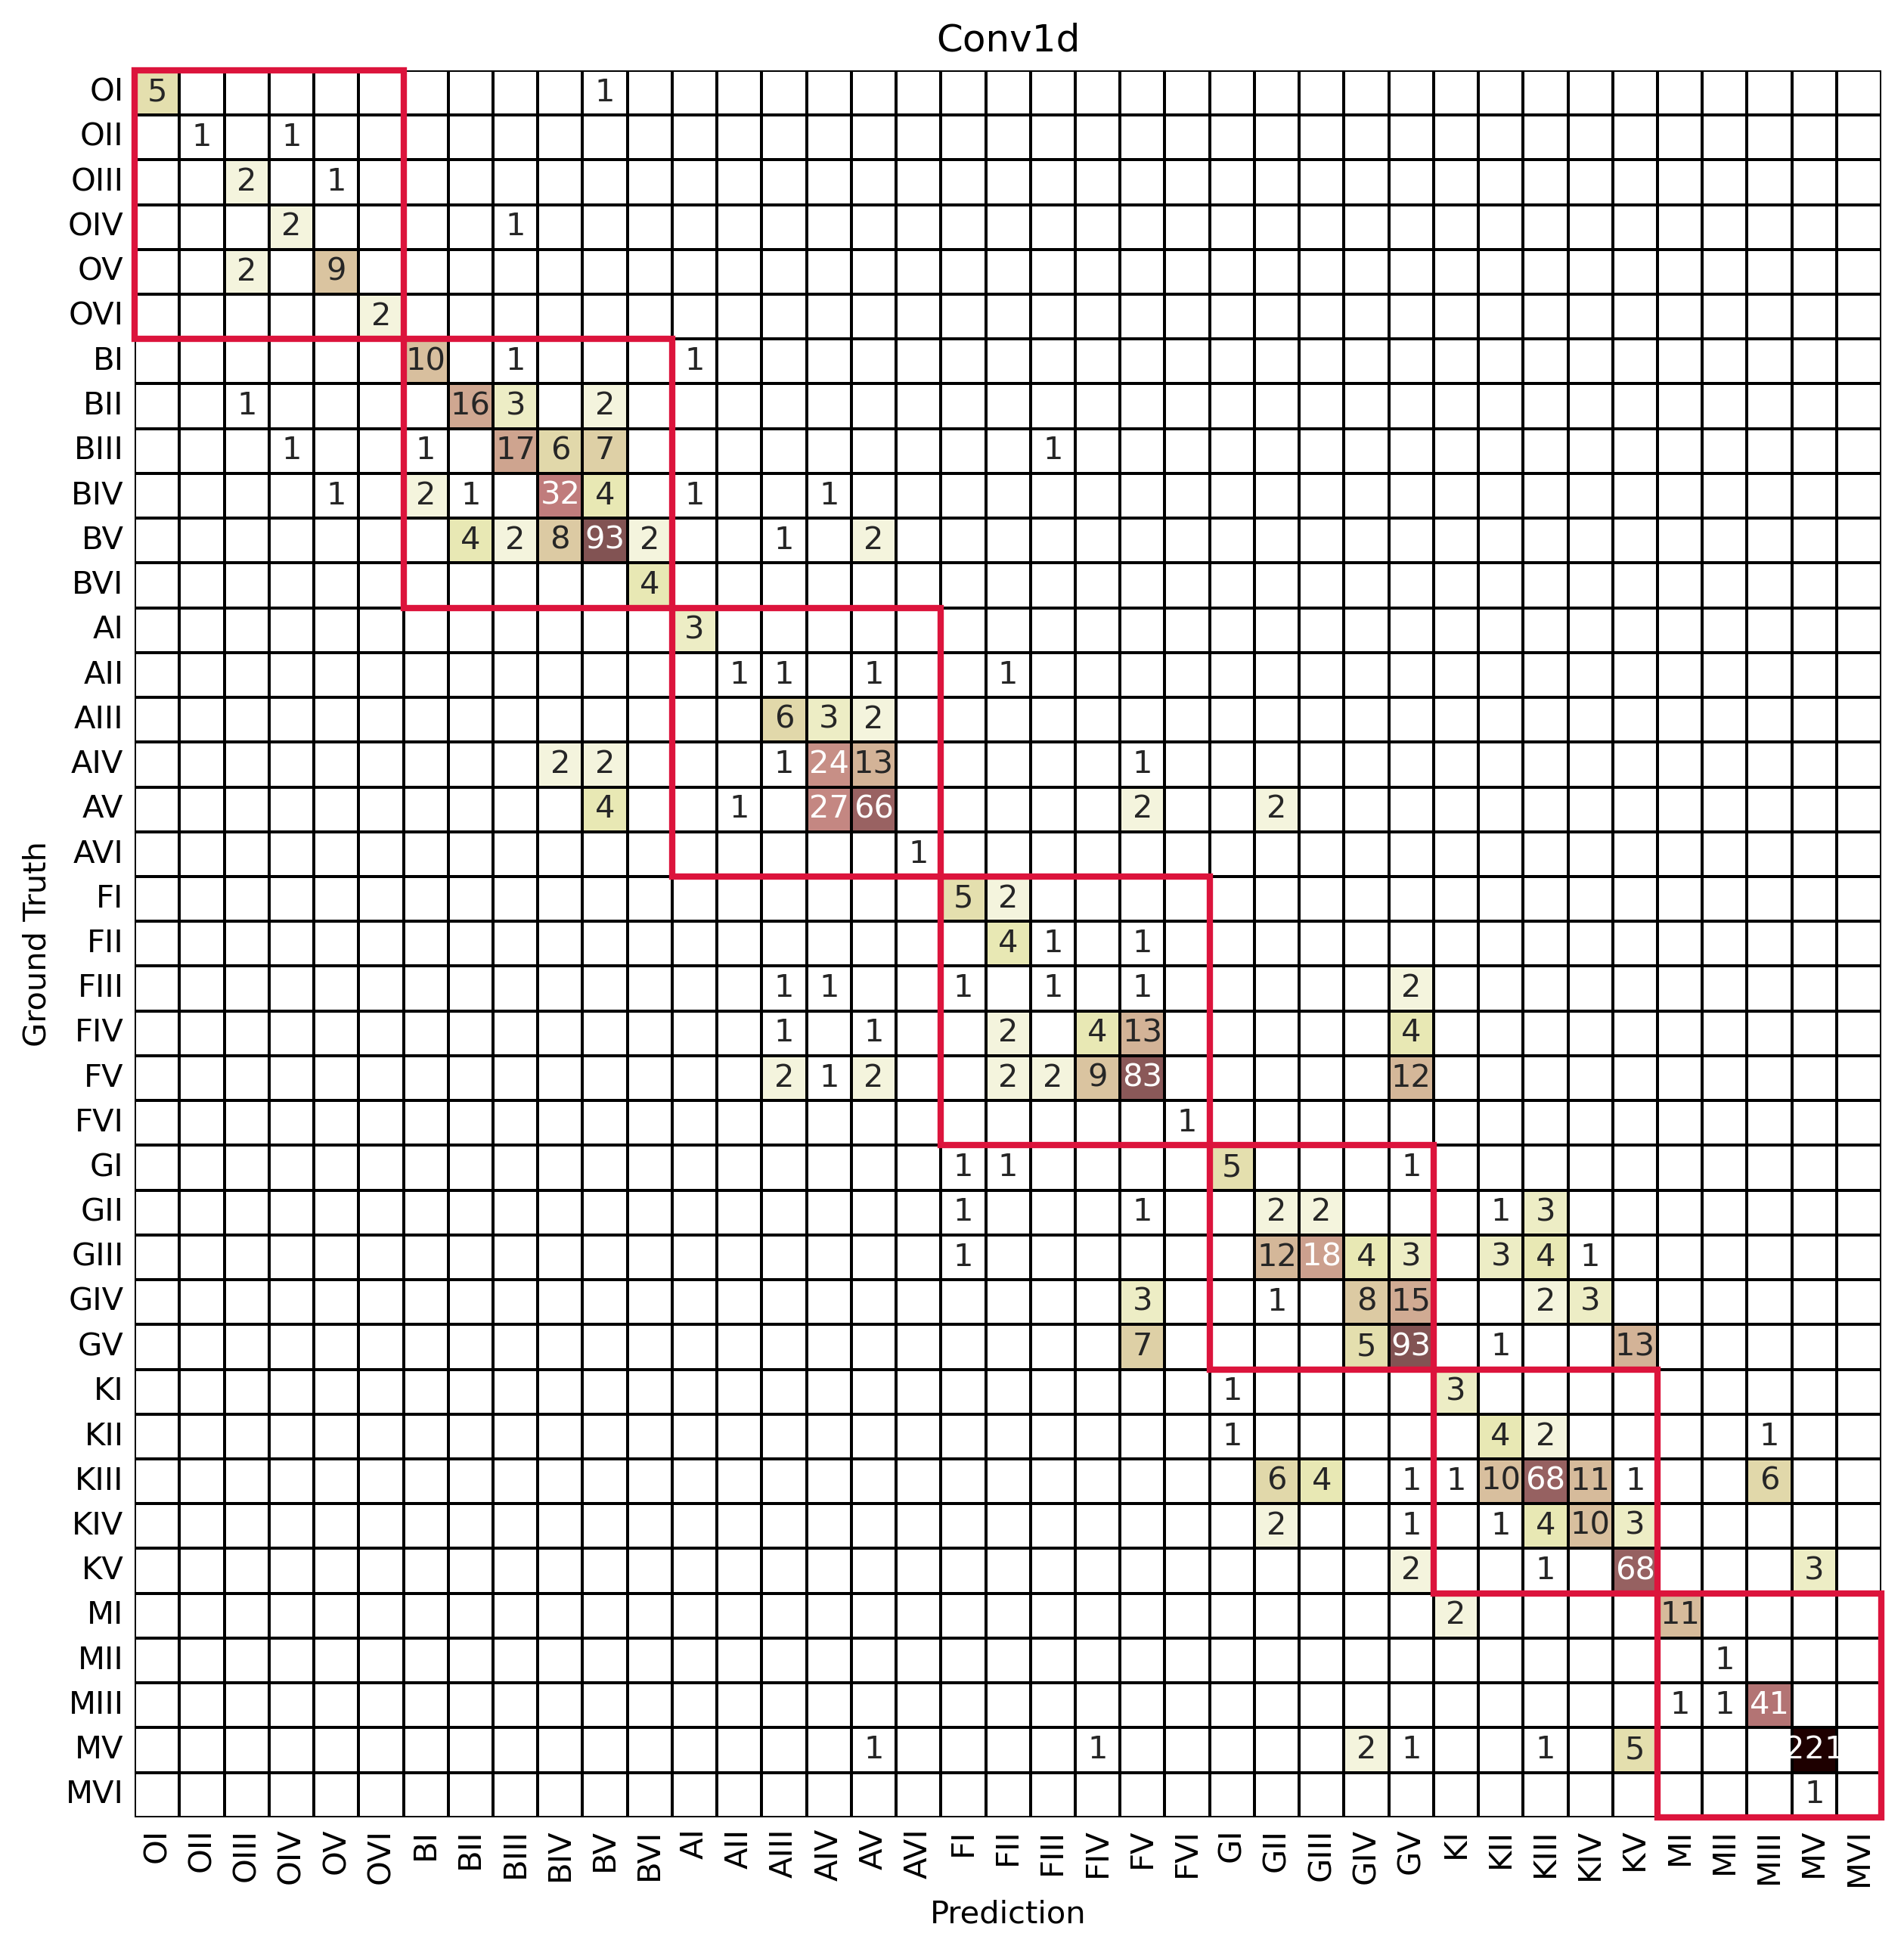

In [ ]:
preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
folder_name = 'final7_starclassifier4_test'
path = f'models/weights/conv1d/cls/{folder_name}'
best_i = 118

classifier3 = StarClassifier4(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

F1 Macro: 61.04%
Mean Absolute Error: 0.22
Q-Weighted Kappa: 97.39%, 60.25%


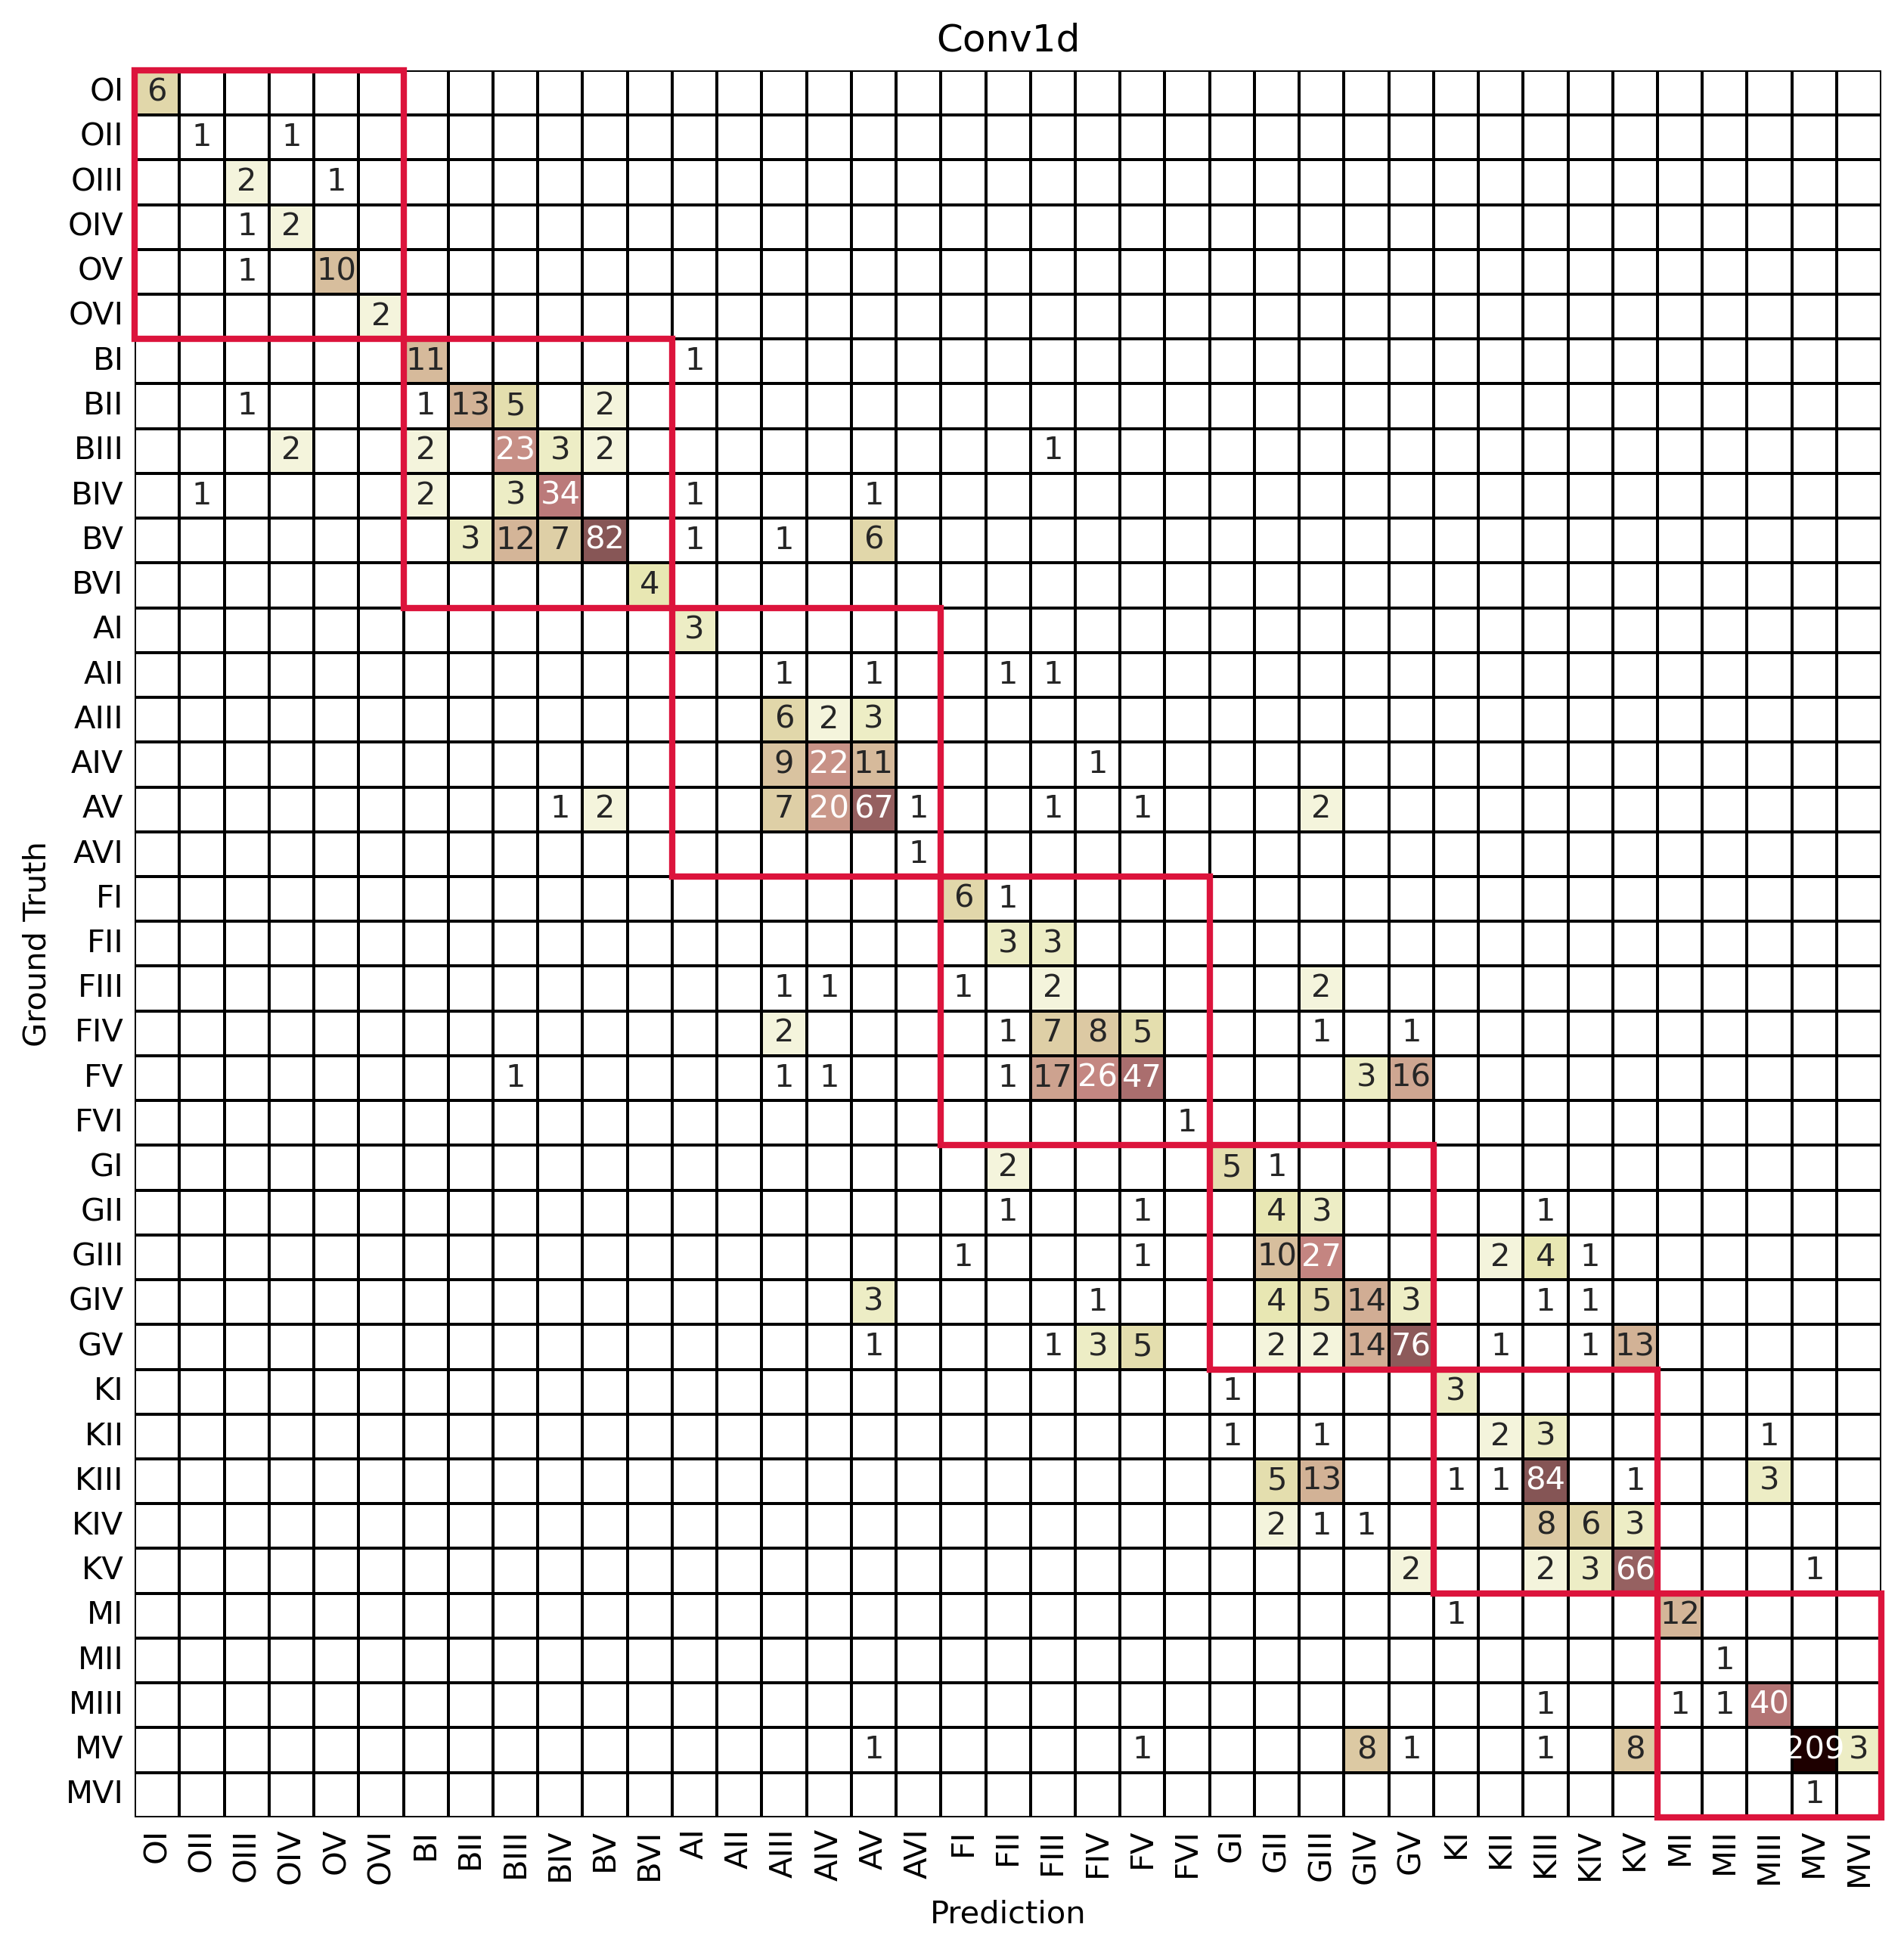

In [ ]:
preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
folder_name = 'final7_starclassifier4_test'
path = f'models/weights/conv1d/cls/{folder_name}'
best_i = 56

classifier3 = StarClassifier4(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

F1 Macro: 58.82%
Mean Absolute Error: 0.21
Q-Weighted Kappa: 96.28%, 50.74%


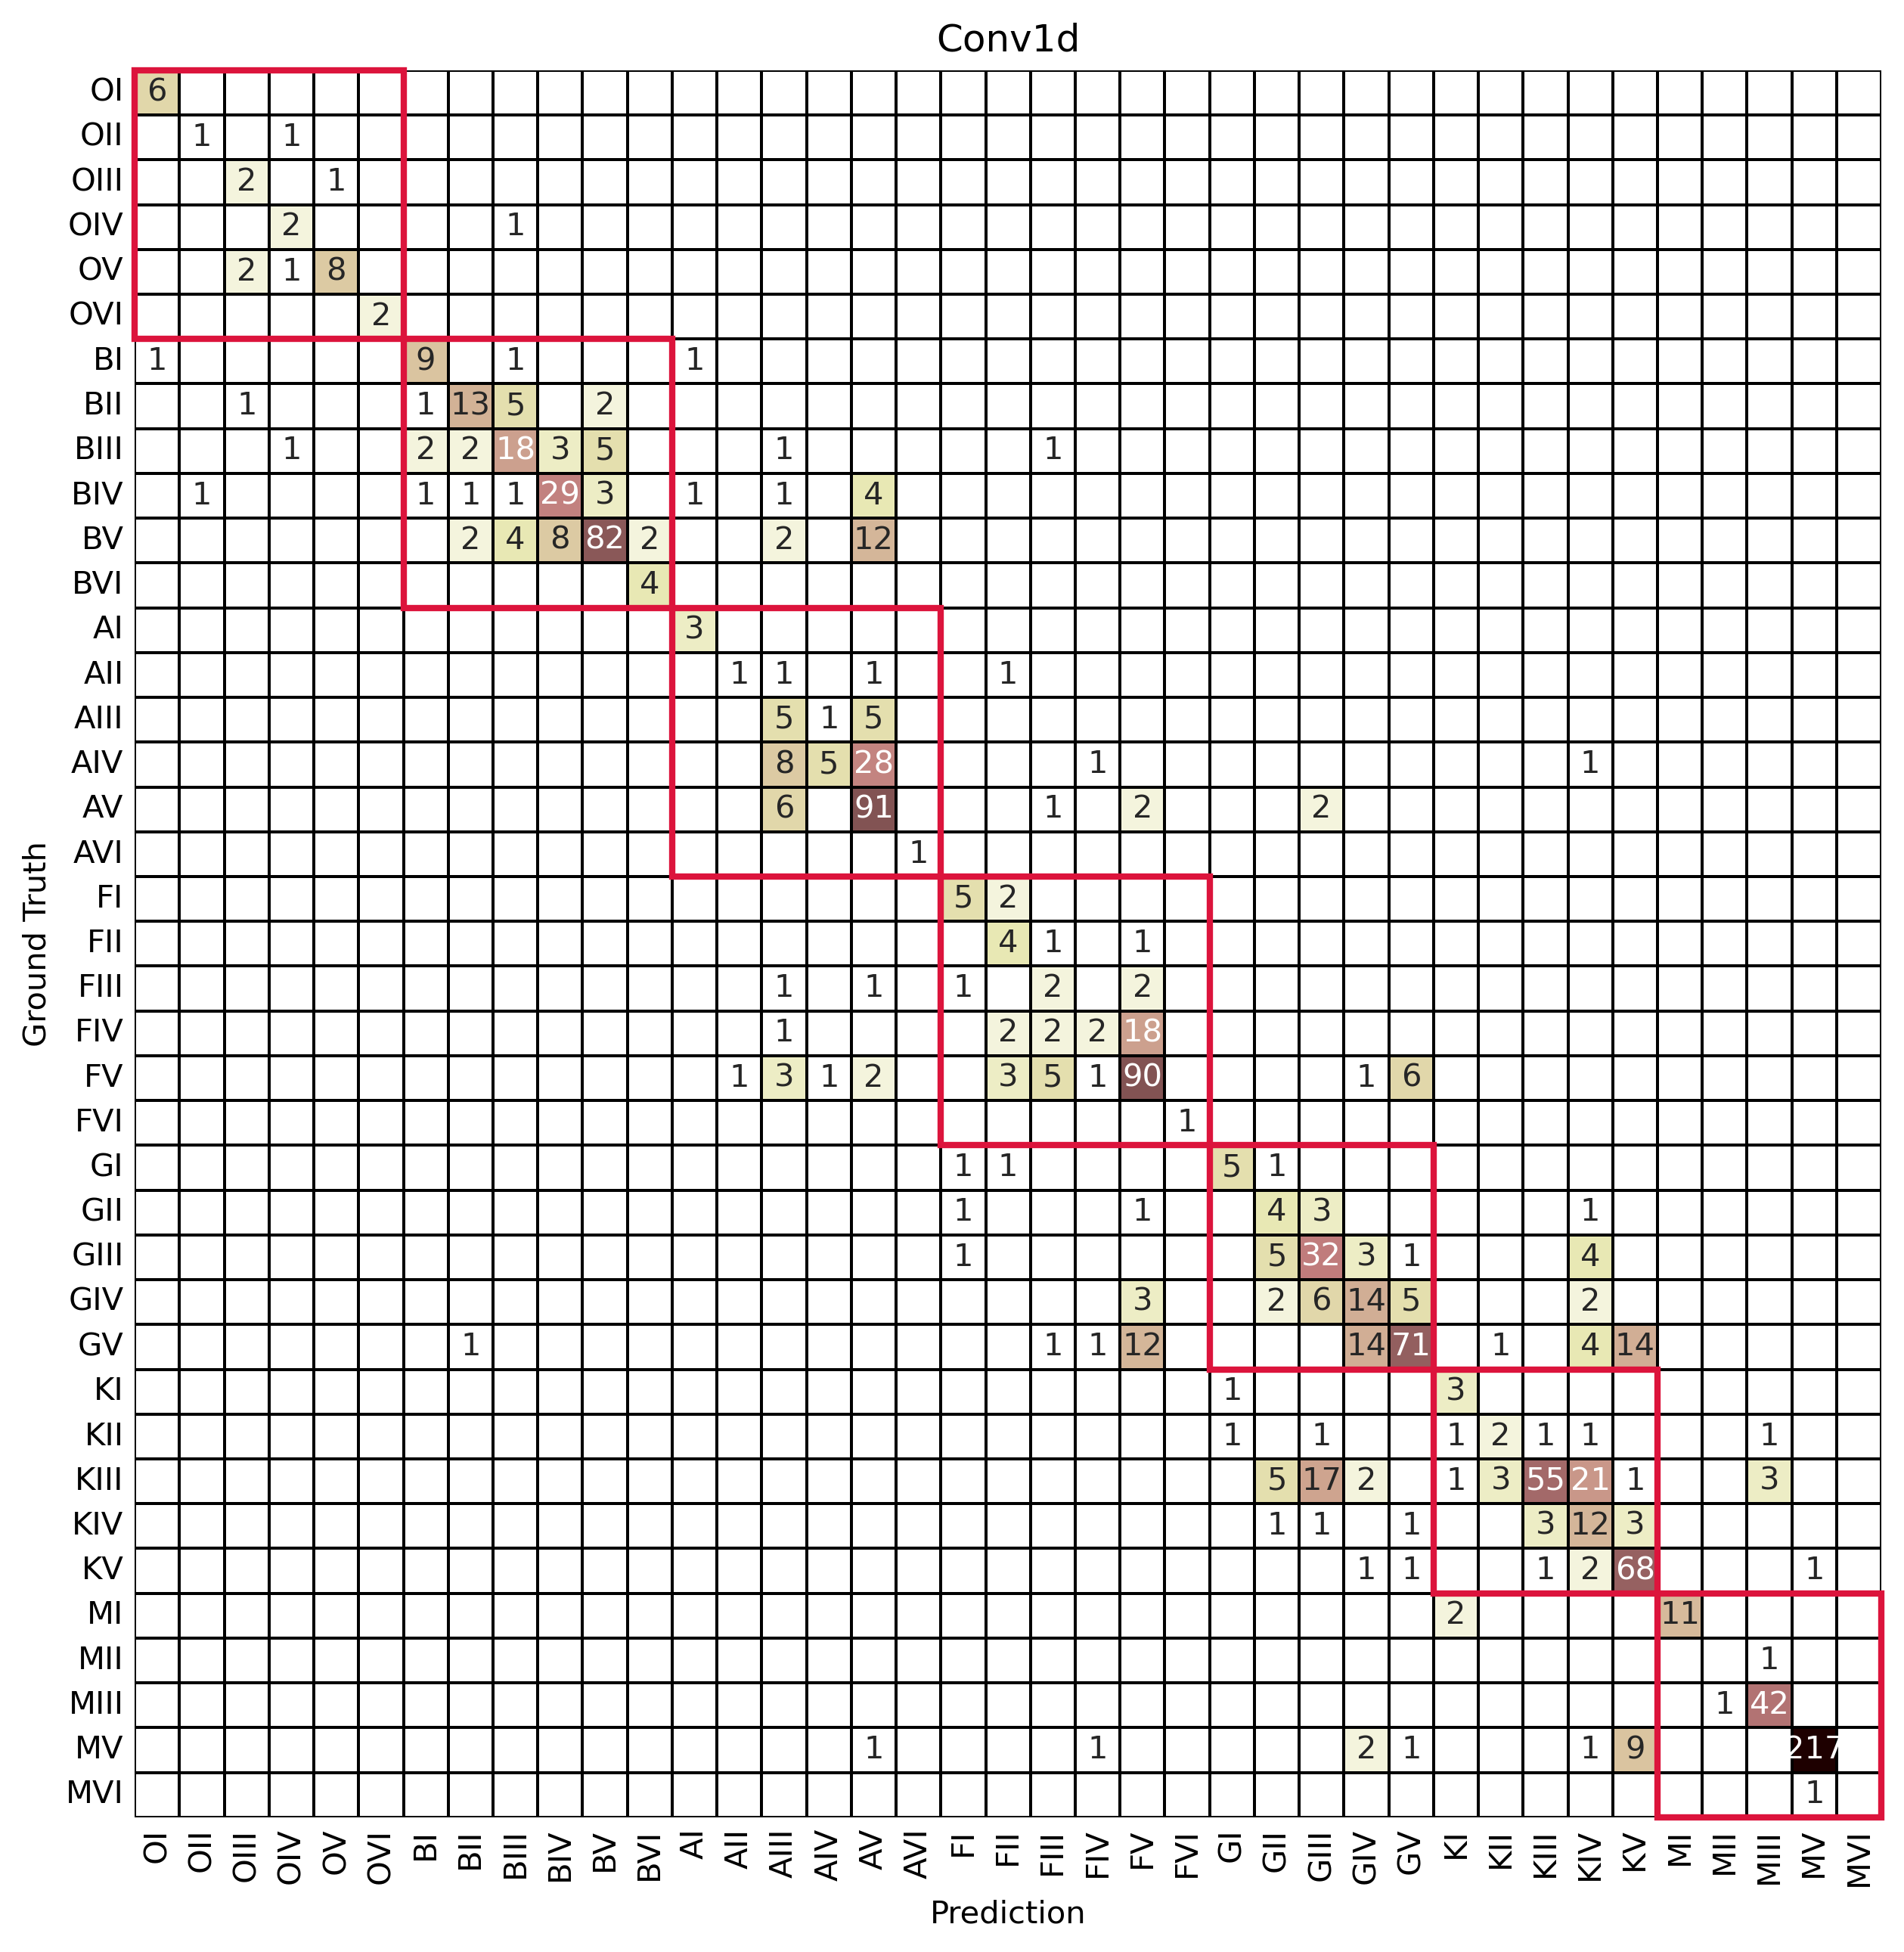

In [ ]:
preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
folder_name = 'final7_starclassifier4_test'
path = f'models/weights/conv1d/cls/{folder_name}'
best_i = 148

classifier3 = StarClassifier4(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

In [ ]:
sm.report('', False)
sm.report('temp', False)
sm.report('lum', False)

              precision    recall  f1-score   support

          OI     0.8571    1.0000    0.9231         6
         OII     0.5000    0.5000    0.5000         2
        OIII     0.4000    0.6667    0.5000         3
         OIV     0.4000    0.6667    0.5000         3
          OV     0.8889    0.7273    0.8000        11
         OVI     1.0000    1.0000    1.0000         2
          BI     0.6923    0.7500    0.7200        12
         BII     0.6842    0.5909    0.6341        22
        BIII     0.6000    0.5455    0.5714        33
         BIV     0.7250    0.6905    0.7073        42
          BV     0.8913    0.7321    0.8039       112
         BVI     0.6667    1.0000    0.8000         4
          AI     0.6000    1.0000    0.7500         3
         AII     0.5000    0.2500    0.3333         4
        AIII     0.1724    0.4545    0.2500        11
         AIV     0.7143    0.1163    0.2000        43
          AV     0.6276    0.8922    0.7368       102
         AVI     1.0000    

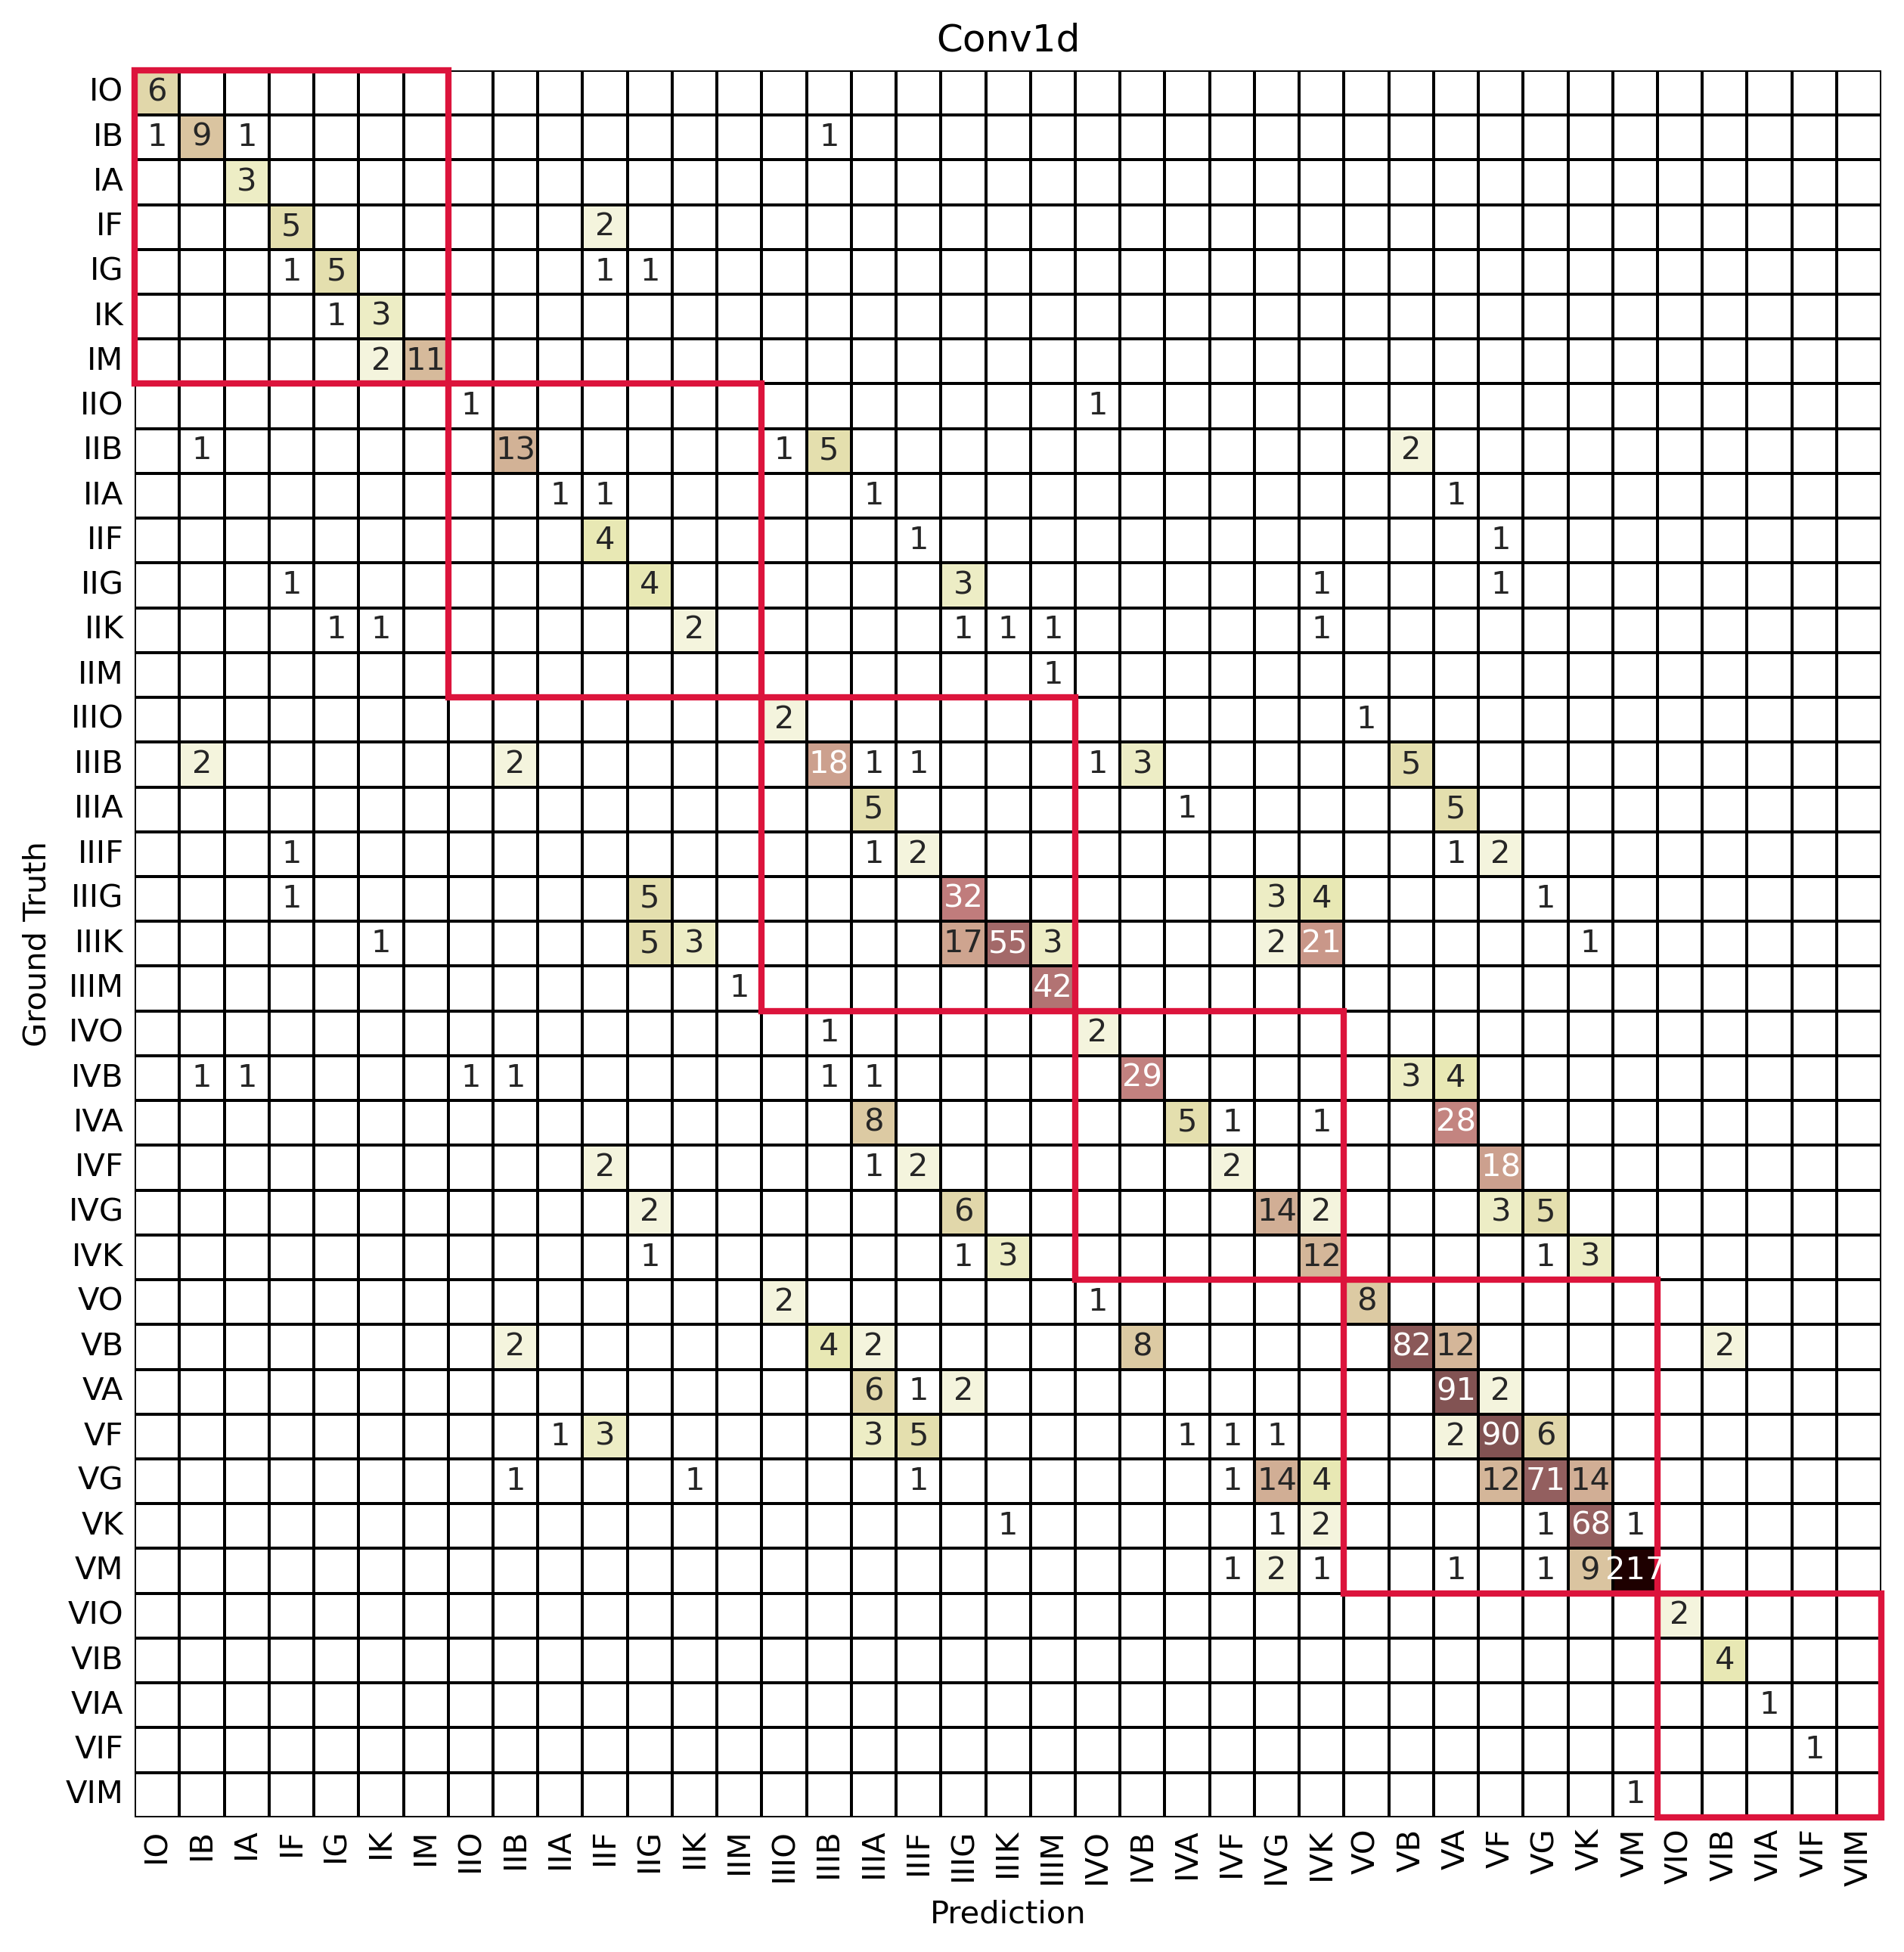

In [ ]:
sm.draw_cm('Conv1d', 300, True)

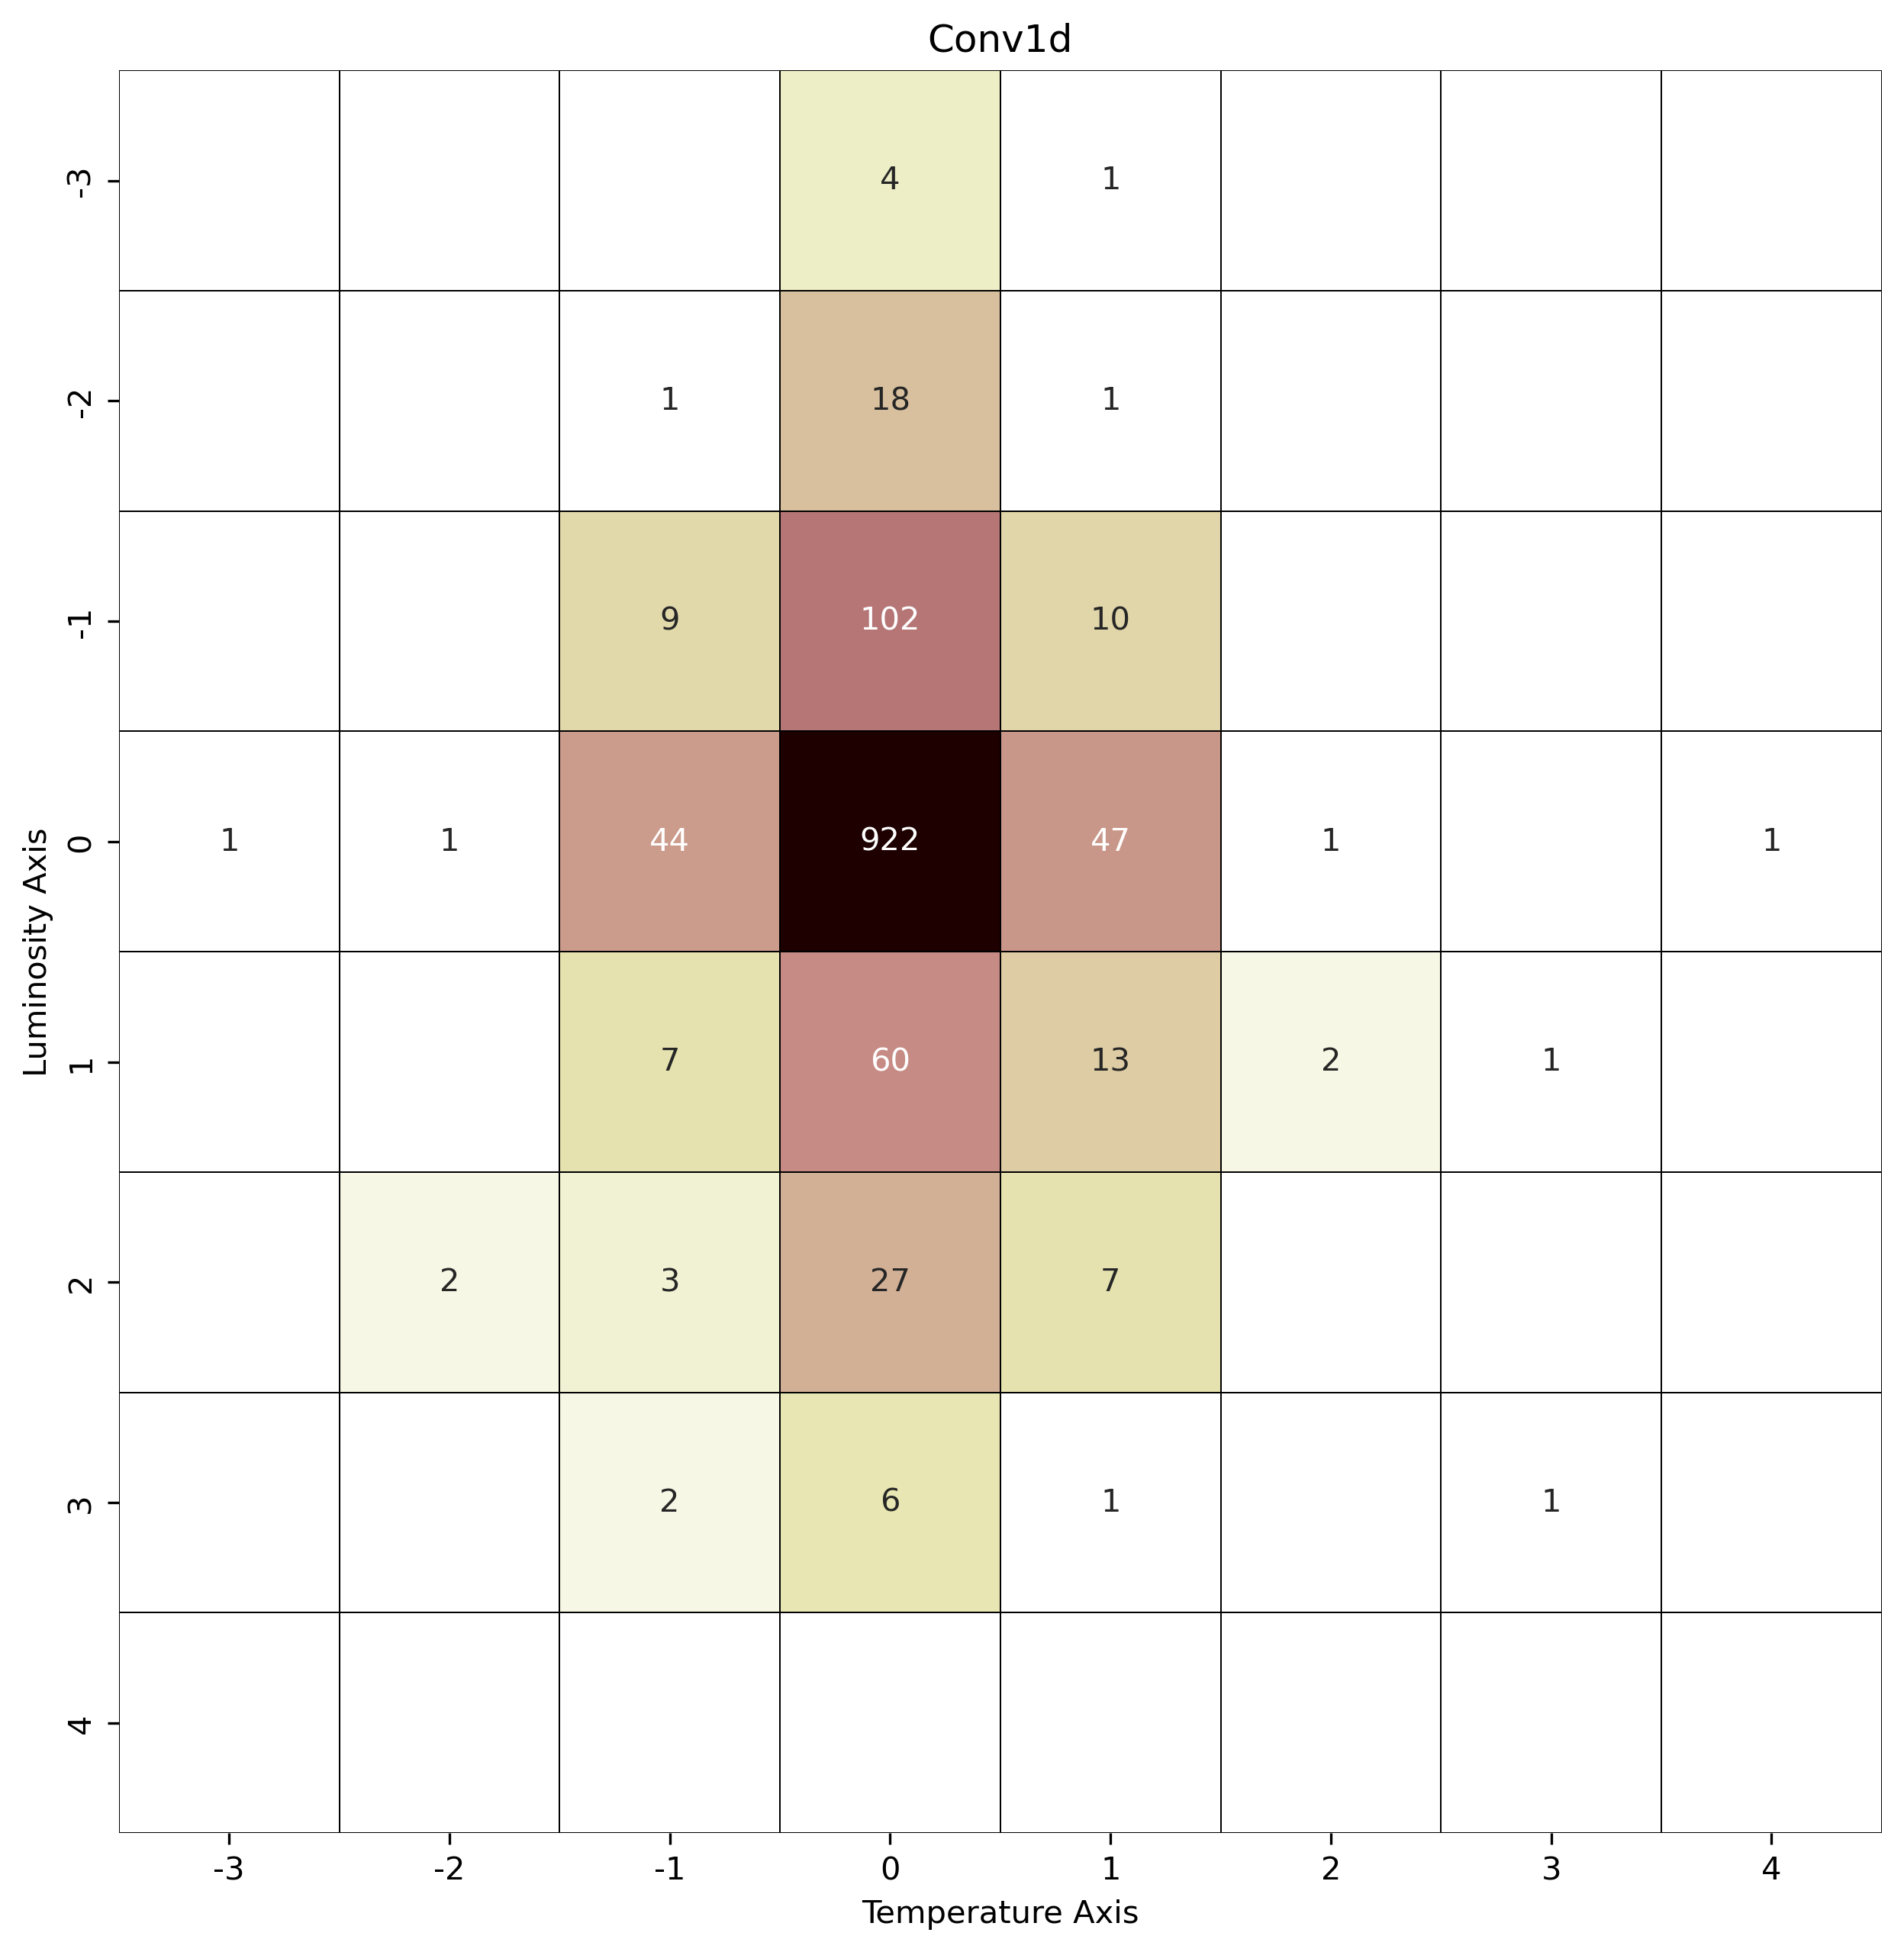

In [ ]:
sm.draw_ord_cm('Conv1d', 300)

In [ ]:
torch.onnx.export(classifier3,torch.randn(16,2305).cuda(), 'test.onnx')

/home/oban/Desktop/Volga/stellar-classification/models/conv1d.py:371: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if get_size:


Text(0.5, 1.0, 'Quadratic Weighted Kappa Scores')

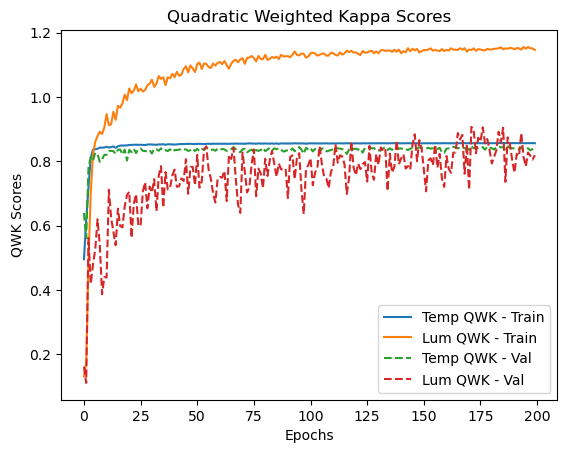

In [ ]:
temp = np.mean(np.unique(
    label_f.to_regr(label_f.unique,idx=False)[:,0],
    return_counts=True)[1])

lum = np.mean(np.unique(
    label_f.to_regr(label_f.unique,idx=False)[:,1],
    return_counts=True)[1])

t_qwk_t, l_qwk_t = zip(*[x[2] for x in metrics])
t_qwk_v, l_qwk_v = zip(*[x[5] for x in metrics])

plt.plot(np.array(t_qwk_t)*temp/lum)
plt.plot(np.array(l_qwk_t)*lum/temp)
plt.plot(np.array(t_qwk_v)*temp/lum, linestyle='--')
plt.plot(np.array(l_qwk_v)*lum/temp, linestyle='--')
plt.legend([
    'Temp QWK - Train',
    'Lum QWK - Train',
    'Temp QWK - Val',
    'Lum QWK - Val'])
plt.xlabel('Epochs')
plt.ylabel('QWK Scores')
plt.title('Quadratic Weighted Kappa Scores')

In [ ]:
def f1(set):
    test_iter = split_dataset(flux, labels, CustomTensorDataset, set)
    test_loader = DataLoader(test_iter, 256)
    preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
    sm = stellar_metrics(label_f, preds, actuals, True, False)
    f1_sc = sm.f1_macro()
    return f1_sc

from scipy.stats import bootstrap

x = bootstrap((test,),f1,n_resamples=10, random_state=10)

/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/scipy/stats/_resampling.py:153: RuntimeWarning: invalid value encountered in scalar divide
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/scipy/stats/_resampling.py:155: RuntimeWarning: invalid value encountered in scalar divide
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))
<ipython-input-89-d96995b33553>:12: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  x = bootstrap((test,),f1,n_resamples=10, random_state=10)


In [ ]:
x

BootstrapResult(confidence_interval=ConfidenceInterval(low=nan, high=nan), bootstrap_distribution=array([0.62622481, 0.59194327, 0.60924614, 0.59997734, 0.61318495,
       0.62410111, 0.59778688, 0.60415849, 0.61362781, 0.62574003]), standard_error=0.012201552939131081)

(array([1., 1., 1., 1., 0., 1., 2., 0., 0., 3.]),
 array([0.59194327, 0.59537143, 0.59879958, 0.60222773, 0.60565589,
        0.60908404, 0.61251219, 0.61594035, 0.6193685 , 0.62279665,
        0.62622481]),
 <BarContainer object of 10 artists>)

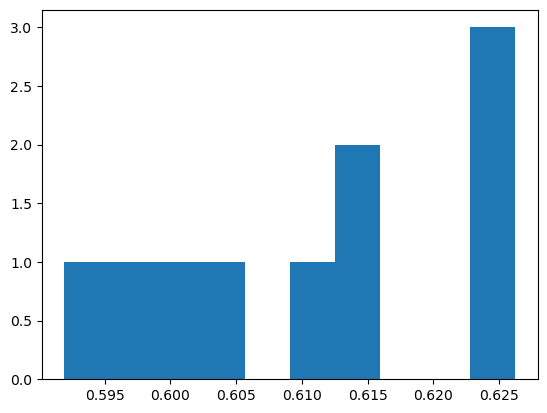

In [ ]:
plt.hist(x.bootstrap_distribution)

(array([1., 1., 1., 1., 0., 1., 2., 0., 0., 3.]),
 array([0.59194327, 0.59537143, 0.59879958, 0.60222773, 0.60565589,
        0.60908404, 0.61251219, 0.61594035, 0.6193685 , 0.62279665,
        0.62622481]),
 <BarContainer object of 10 artists>)

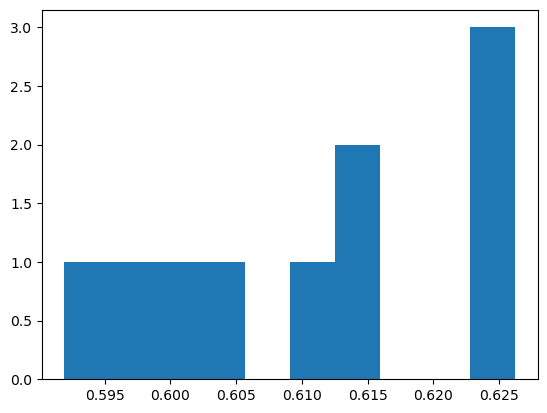

In [ ]:
plt.hist(x.bootstrap_distribution,bins=10)